In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [32]:
data = pd.read_csv('../webinar_2/data/retail_train.csv')
data

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2396799,1613,41655820646,663,16102849,1,2.00,3262,-1.15,1231,95,0.0,0.0
2396800,1001,41655829421,663,13217063,1,1.69,3131,0.00,2231,95,0.0,0.0
2396801,1001,41655829421,663,13217800,1,1.69,3131,0.00,2231,95,0.0,0.0
2396802,1167,41656790510,663,6410462,22451,43.98,3385,-0.65,1059,95,0.0,0.0


In [33]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [34]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [35]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [36]:
%%time

items = data_train.item_id.unique()

result['random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))

result.head(2)

Wall time: 3.56 s


,user_id,actual,random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[914826, 9297388, 1056531, 1950545, 1096842]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[898844, 13511450, 6772875, 859924, 9524291]"


### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [44]:
#функция для получения весов товаров в зависимости от объёма продаж в денежном эквиваленте
def get_items_weights(df):
    total_sales=df['sales_value'].sum()
    items_weights=df.groupby('item_id').agg({'sales_value':'sum'}).reset_index().rename(columns={'sales_value':'weight'})
    items_weights['weight']=items_weights['weight'].apply(lambda x: x/total_sales)
    return items_weights

In [55]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    items = np.array(items_weights['item_id'])
    weights=np.array(items_weights['weight'])
    recs = np.random.choice(items, size=n, p=weights, replace=False) #используем параметр p метода choice в который передадим веса товаров
    
    
    return recs.tolist()

In [56]:
%%time

# your_code
items_weights=get_items_weights(data_train)

result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights, n=5))

result.head(2)

Wall time: 1.97 s


,user_id,actual,random_recommendation,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[914826, 9297388, 1056531, 1950545, 1096842]","[1014915, 844179, 5568729, 1037729, 986409]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[898844, 13511450, 6772875, 859924, 9524291]","[883003, 993638, 902094, 860776, 1046638]"


Проверим, отличается ли качество взвешенной случайной рекомендации от обычной случайной рекомендации

In [57]:
# Функции из 1-ого вебинара
import os, sys
    
from metrics import precision_at_k, recall_at_k

In [59]:
for name_col in result.columns[1:]:
    print(f"{round(result.apply(lambda row: precision_at_k(row[name_col], row['actual']), axis=1).mean(),4)}:{name_col}")

1.0:actual
0.0006:random_recommendation
0.0227:weighted_random_recommendation


**Видим, что качество взвешенной случайной рекомендации выше**

## Задание 2. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая случаный на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.

Посчитаем случайный на топ_5000 товаров

In [66]:
#функция для получения Топ 5000 товаров по количеству проданного(можно варьировать какой Топ получать и по какому показателю)
def get_top(df, column='quantity', top=5000):
    top_df=df.groupby('item_id').agg({f'{column}':'sum'}).reset_index().sort_values(column, ascending=False).head(5000).item_id.tolist()
    return top_df

In [69]:
%%time

items = get_top(data_train)

result['top5000_random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))

result.head(2)

Wall time: 993 ms


,user_id,actual,random_recommendation,weighted_random_recommendation,top5000_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[914826, 9297388, 1056531, 1950545, 1096842]","[1014915, 844179, 5568729, 1037729, 986409]","[827802, 1139471, 987838, 7168383, 1048507]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[898844, 13511450, 6772875, 859924, 9524291]","[883003, 993638, 902094, 860776, 1046638]","[975938, 1069714, 5591520, 5584847, 5590158]"


Посчитаем качество случайной рекомендации на товарах из Топ-5000 по количеству проданного товара и по сумме продаж

In [71]:
%%time

items = get_top(data_train, column='sales_value')

result['top5000_sales_random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))

result.head(2)

Wall time: 1.01 s


,user_id,actual,random_recommendation,weighted_random_recommendation,top5000_random_recommendation,top5000_sales_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[914826, 9297388, 1056531, 1950545, 1096842]","[1014915, 844179, 5568729, 1037729, 986409]","[827802, 1139471, 987838, 7168383, 1048507]","[993044, 9296778, 948254, 903325, 1107032]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[898844, 13511450, 6772875, 859924, 9524291]","[883003, 993638, 902094, 860776, 1046638]","[975938, 1069714, 5591520, 5584847, 5590158]","[931255, 904812, 397896, 951197, 1130716]"


In [72]:
for name_col in result.columns[1:]:
    print(f"{round(result.apply(lambda row: precision_at_k(row[name_col], row['actual']), axis=1).mean(),4)}:{name_col}")

1.0:actual
0.0006:random_recommendation
0.0227:weighted_random_recommendation
0.0054:top5000_random_recommendation
0.0067:top5000_sales_random_recommendation


**Видим, что качество случайной рекомендации возросло, но не на столько, как при использовании взвешенной случайной рекомендации**

б. посчитаем качество ItemItemRecommender, выбирая число соседей K

In [74]:
top_5000= get_top(data_train)

In [75]:
data_train.loc[ ~ data_train['item_id'].isin(top_5000), 'item_id'] = 6666
data_train.head(100)

D:\ProgramData\Anaconda3\envs\GPUenv\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1060,26985040735,1,9553288,1,8.49,315,0.00,1251,1,0.0,0.0
96,1351,26985052379,1,903230,1,0.99,447,-0.30,1955,1,0.0,0.0
97,744,26985165432,1,6666,0,0.00,31582,0.00,1119,1,0.0,0.0
98,212,26985205886,1,822346,1,1.25,288,-0.34,1341,1,0.0,0.0


In [76]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

In [77]:
# создаем словари мапинга между id бизнеса к строчному id матрицы

userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

Подбираем количество соседей:

In [84]:
neighbors=np.arange(1,21)
fltrs=[None,[itemid_to_id[6666]]]
max_score, m_neighbor, m_fltr = 0,0,0
res_dict={'no_fltr':[[],[]],'fltr':[[],[]]}
for neighbor in neighbors:
    for fltr in fltrs:
        current_key='fltr' if fltr else 'no_fltr'
        model = ItemItemRecommender(K=neighbor, num_threads=4)
        model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=False)
        
        result['itemitem'] = result['user_id'].apply(lambda user_id: [
                                     id_to_itemid[rec[0]]  for rec in model.recommend(userid=userid_to_id[user_id], 
                                                user_items=sparse_user_item,   # на вход user-item matrix
                                                N=5, 
                                                filter_already_liked_items=False, 
                                                filter_items=fltr, 
                                                recalculate_user=True)
                                                             ])
        score=round(result.apply(lambda row: precision_at_k(row['itemitem'], row['actual']), axis=1).mean(),4)
        res_dict[current_key][0].append(score)
        res_dict[current_key][1].append(neighbor)
        
        if score> max_score:
            max_score, m_neighbor, m_fltr=score, neighbor, 'filtered by 6666' if fltr else 'non filtered'
print(f'Лучший скор: {max_score}, K_neighbors: {m_neighbor}, условие фильтрации: {m_fltr}')

            
        

Лучший скор: 0.2199, K_neighbors: 1, условие фильтрации: filtered by 6666


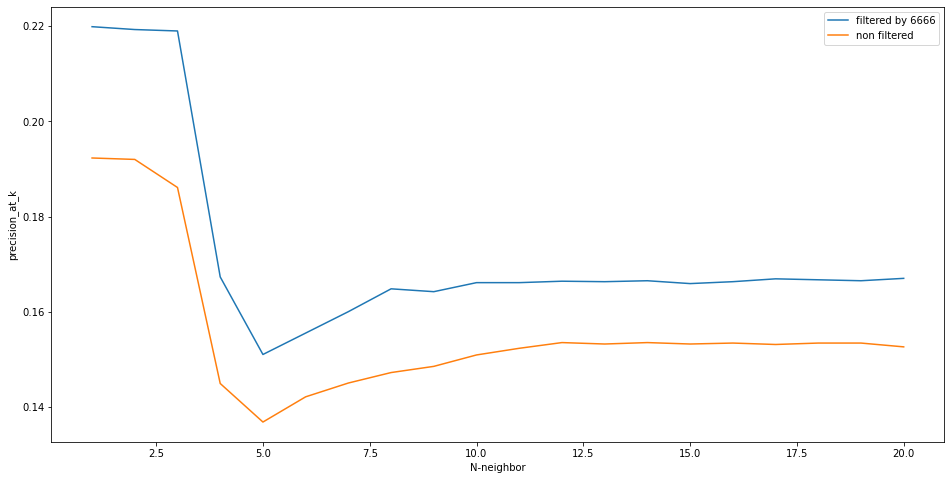

In [83]:
plt.figure(figsize=(16, 8))
plt.plot(res_dict['fltr'][1], res_dict['fltr'][0], label='filtered by 6666')
plt.plot(res_dict['no_fltr'][1], res_dict['no_fltr'][0], label='non filtered')
plt.xlabel('N-neighbor')
plt.ylabel('precision_at_k')
plt.legend()
plt.show()